In [67]:
from diabetic_env_discretized import Diabetic2Env
import gym
import numpy as np
import random
from stable_baselines3 import DQN
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from torch.optim import Adam
import itertools
import torch.nn as nn
import seaborn as sns


In [ ]:
class RewardPlottingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardPlottingCallback, self).__init__(verbose)
        self.rewards = []
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_count = 0

    def _on_step(self):
        # Capture rewards and keep track of episode lengths
        self.rewards.append(self.locals['rewards'])
        if self.locals['dones'][0]:
            self.episode_count += 1
            self.episode_rewards.append(sum(self.rewards))
            self.episode_lengths.append(len(self.rewards))
            self.rewards = []
        return True

    def _on_training_end(self):
        # Plot the rewards and lengths at the end of training
        self.plot_rewards()

    def plot_rewards(self):
        plt.figure(figsize=(12, 6))
        
        # Plot Episode Rewards
        plt.subplot(2, 1, 1)
        plt.plot(self.episode_rewards, label='Episode Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Cumulative Rewards per Episode')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [ ]:
diabetic_sim = Diabetic2Env()

In [ ]:
diabetic_sim.set_episode_length(10)

In [ ]:
model = DQN(
        "MlpPolicy",
        diabetic_sim,
        verbose=1,
        train_freq=16,
        gradient_steps=8,
        gamma=0.99,
        exploration_fraction=0.2,
        exploration_final_eps=0.07,
        target_update_interval=600,
        learning_starts=1000,
        buffer_size=10000,
        batch_size=128,
        learning_rate=1e-4,
        policy_kwargs=dict(activation_fn=nn.ReLU, net_arch=[256, 256, 256]),
        seed=2,
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
mean_reward, std_reward = evaluate_policy(
    model,
    diabetic_sim,
    deterministic=True,
    n_eval_episodes=20,
)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/Users/emmythamakaison/anaconda3/envs/cs238_finalproj/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:-140.26 +/- 2.00


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 143      |
|    ep_rew_mean      | -123     |
|    exploration_rate | 0.967    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 1298     |
|    time_elapsed     | 1        |
|    total_timesteps  | 1430     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 59720    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 143      |
|    ep_rew_mean      | -118     |
|    exploration_rate | 0.934    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 885      |
|    time_elapsed     | 3        |
|    total_timesteps  | 2860     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.33     |
|    n_updates      

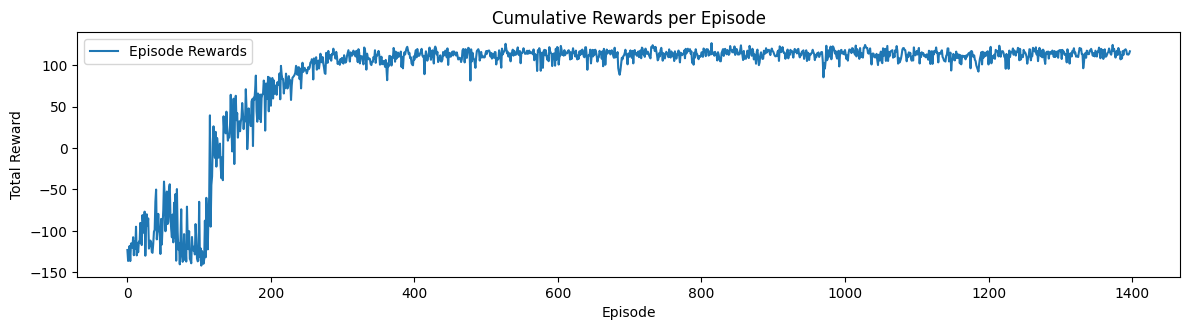

In [ ]:
# model.learn(total_timesteps=10000, callback=RewardPlottingCallback(), log_interval=4)
model.learn(int(2e5), callback=RewardPlottingCallback(), log_interval=10)

In [ ]:
model.save("dqn_diabetes")

In [ ]:
mean_reward, std_reward = evaluate_policy(model, diabetic_sim, deterministic=True, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:104.41 +/- 3.28


In [71]:
test_model = DQN.load("dqn_diabetes")

In [72]:
def random_model(env, num_episodes):
    """
    Used as a baseline, the model would randomly choose action for each state
    """
    nA = env.action_space.n
    
    #episode_lengths=np.zeros(num_episodes)
    random_episode_rewards=np.zeros(num_episodes)
    final_reward = []
    glucose_levels = []
    start_track = False
    
    for i_episode in range(num_episodes):
        if i_episode == num_episodes - 1:
            start_track = True
        
        last_reward = random_episode_rewards[i_episode - 1]
        # print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, last_reward))
        # sys.stdout.flush()
        
        # TODO: Implement this!
        state = env.reset()
        
        for t in itertools.count():
            
            # sample the action from the epsilon greedy policy
            action = np.random.choice(nA)
            
            # Perform the action -> Get the reward and observe the next state
            new_state, reward, terminated, _ = env.step(action)
            new_action = np.random.choice(nA)
            
            if start_track:
                final_reward.append(reward)
                        
            random_episode_rewards[i_episode] += reward       
            
            # update current state
            state = new_state

            glucose_levels.append(state[0])
            
            if terminated:
                break
    
    return random_episode_rewards, final_reward, glucose_levels

In [69]:
## ACCUMULATING RANDOM REWARD
random_episode_r, random_r, _ = random_model(diabetic_sim, num_episodes=144)

In [ ]:
## ACCUMULATING TEST MODEL REWARD
reward_vec = []
done = False
state = diabetic_sim.reset()
while not done:
    action, _states = test_model.predict(state, deterministic=True)
    next_state, reward, done, info = diabetic_sim.step(action)
    reward_vec.append(reward)
    state = next_state

In [ ]:
random_reward = np.array(random_r).astype(np.double)
xs = np.arange(len(random_r))
s2 = np.isfinite(random_reward)

Text(0.5, 1.0, 'DQN vs Random: Rewards Obtained Throughout Day')

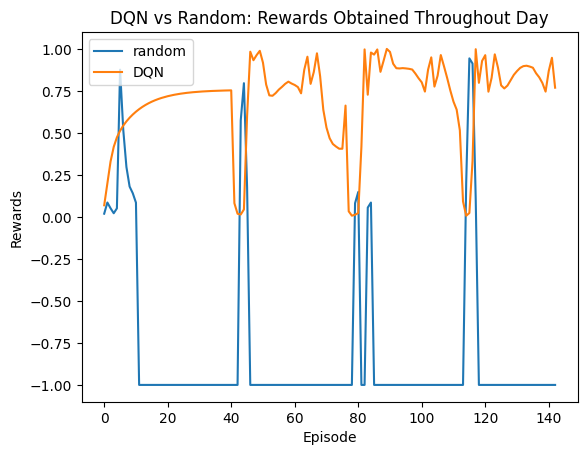

In [ ]:
avfa_reward = np.array(reward_vec).astype(np.double)
xs = np.arange(len(reward_vec))
s1 = np.isfinite(avfa_reward)

plt.plot(xs[s2], random_reward[s2], linestyle='-', label='random')
plt.plot(xs[s1], avfa_reward[s1], linestyle='-', label='DQN')
plt.legend()

plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title('DQN vs Random: Rewards Obtained Throughout Day')

In [73]:
dqn_glucose_levels = []
for episode in range(100):
    state = diabetic_sim.reset()
    done = False
    total_reward = 0

    while not done:
        action, _states = test_model.predict(state, deterministic=True)
        next_state, reward, done, info = diabetic_sim.step(action)
        total_reward += reward
        state = next_state
        dqn_glucose_levels.append(state[0])


In [74]:
_, _, patient_glucose_levels = random_model(diabetic_sim, num_episodes=100)

In [78]:
dqn_glucose_levels = np.array(dqn_glucose_levels)
patient_glucose_levels = np.array(patient_glucose_levels)

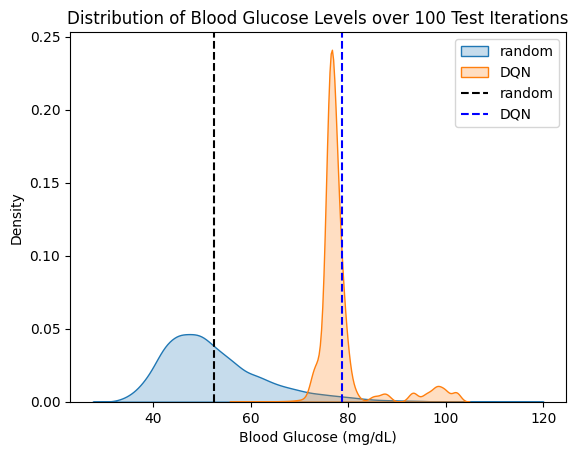

In [82]:
sns.kdeplot(patient_glucose_levels, fill=True, label='random')
sns.kdeplot(dqn_glucose_levels, fill=True, label='DQN')

# Adding vertical lines for mean or target glucose levels if needed
plt.axvline(x=patient_glucose_levels.mean(), color='k', linestyle='--', label='random')
plt.axvline(x=dqn_glucose_levels.mean(), color='b', linestyle='--', label='DQN')

# Adding labels and title
plt.xlabel('Blood Glucose (mg/dL)')
plt.ylabel('Density')
plt.title('Distribution of Blood Glucose Levels over 100 Test Iterations')
plt.legend()

# Display the plot
plt.show()

In [ ]:
total_rewards = []
for episode in range(100):
    state = diabetic_sim.reset()
    done = False
    total_reward = 0

    while not done:
        action, _states = test_model.predict(state, deterministic=True)
        next_state, reward, done, info = diabetic_sim.step(action)
        total_reward += reward
        state = next_state

    total_rewards.append(total_reward)
    # diabetic_sim.render()

average_reward = sum(total_rewards) / 100
print(f"Average Reward: {average_reward}")

Average Reward: 103.92248190793381
